# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark
!pip install -q ipinfo
!pip install https://github.com/matplotlib/basemap/archive/master.zip

  Using cached https://github.com/matplotlib/basemap/archive/master.zip


In [ ]:
!ls -a

.   apache_logs  sample_data		    spark-3.0.0-bin-hadoop3.2.tgz
..  .config	 spark-3.0.0-bin-hadoop3.2  spark-3.0.0-bin-hadoop3.2.tgz.1


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

In [ ]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [ ]:
import urllib.request

In [ ]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0x7f2e48ae5ad0>)

In [ ]:
lines = sc.textFile("apache_logs")

## <b>Zadanie 1</b>
#### Narysować wykres rankingu najpopularniejszych stron źródłowych (referer), z wyłączeniem domeny semicomplete.com

In [ ]:
regex = '(?<=\"http://)www\.(?!semicomplete\.com)\S+(?=\")'

In [ ]:
import re

def mapper(s):
  groups = re.search(regex, s)
  if groups is not None:
    return (groups.group(0).split('/')[0], 1)
  else:
    return (None, 0)  

address = lines.map(mapper)

In [ ]:
addressCounts = address.reduceByKey(lambda a, b: a + b)

In [ ]:
top_address = addressCounts.takeOrdered(20, lambda pair: -pair[1])

In [ ]:
import pandas as pd

df = pd.DataFrame(top_address, columns=['Address', 'Count'])

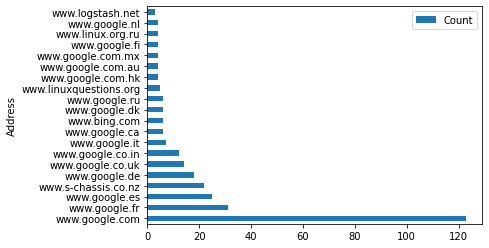

In [ ]:
import matplotlib.pyplot as plt

df.plot.barh(x = 'Address')

## <b>Zadanie 2</b>
#### Narysować wykres słupkowy liczby wywołań (request) na godzinę w zależności od czasu, pogrupowane po kodzie odpowiedzi (200, 404, etc)

In [ ]:
hour_regex = "\[\d+/\w+/\d+:(\d+):"
response_code_regex = "\"(GET|HEAD|POST|OPTIONS).*?\" (\d+)"

def map_line(line):
    hour = int(re.search(hour_regex, line).group(1))
    response_code = int(re.search(response_code_regex, line).group(2))
    return (hour, response_code), 1

requests_counts = lines.map(map_line).reduceByKey(lambda a, b: a + b).collect()

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


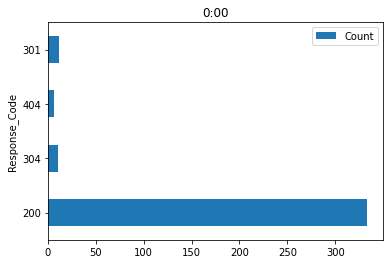

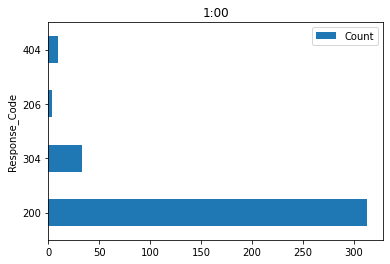

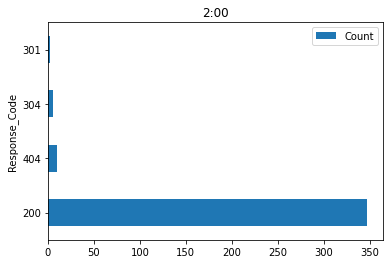

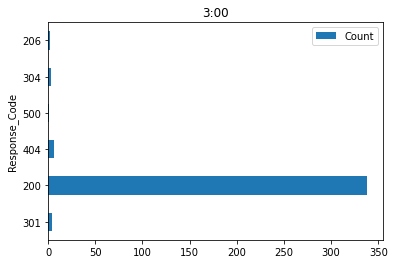

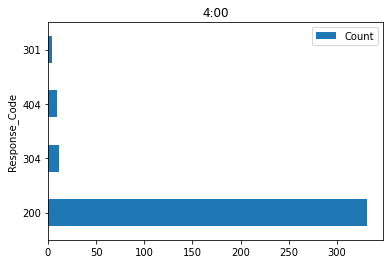

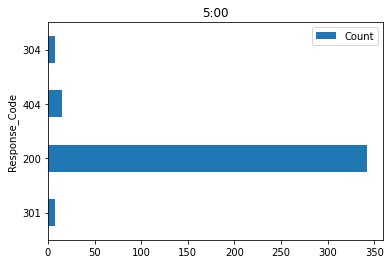

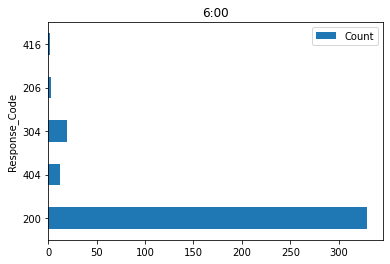

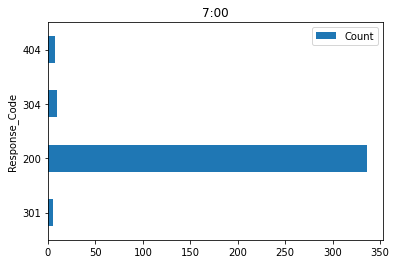

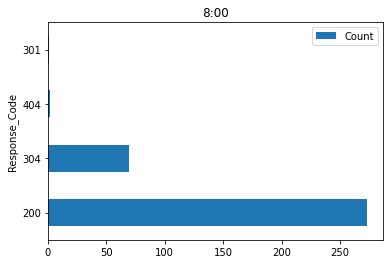

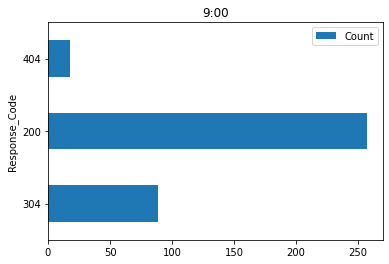

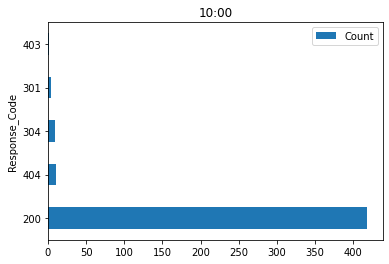

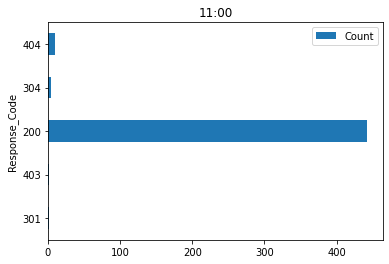

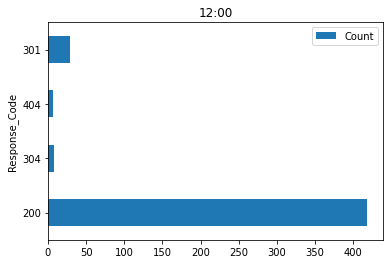

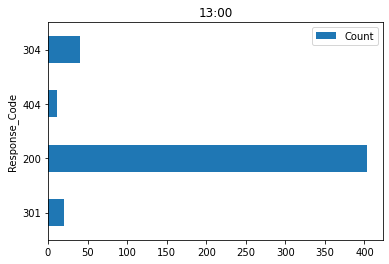

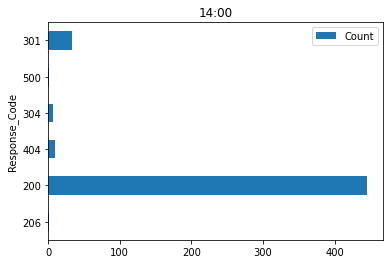

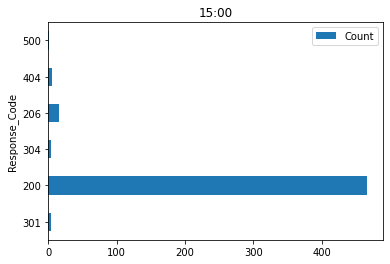

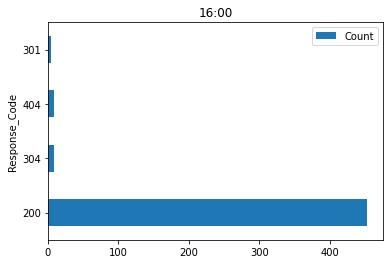

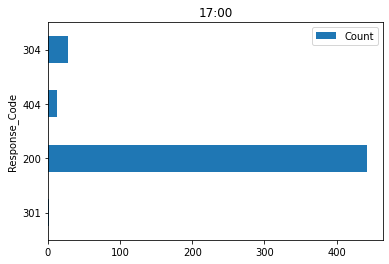

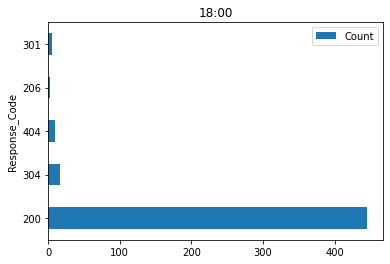

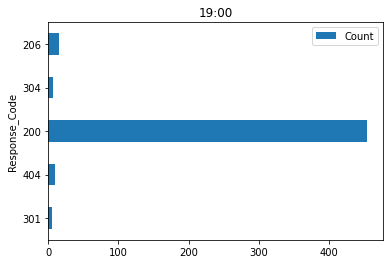

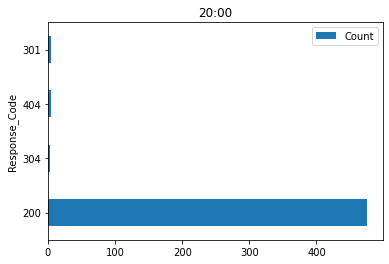

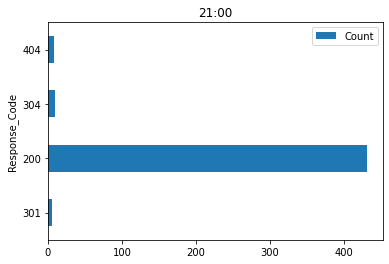

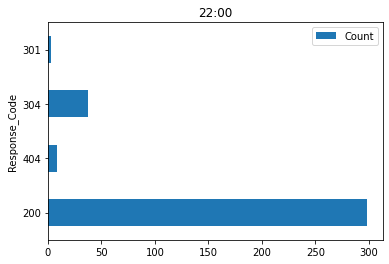

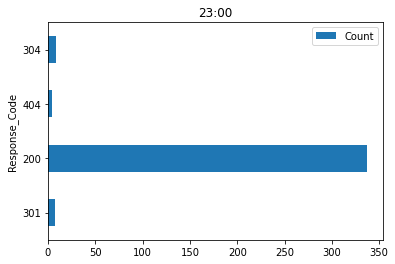

In [ ]:
for h in range(24):

  def filter_by_hour(t):
    return t[0][0] == h
  def remove_hour(t):
    return [t[0][1], t[1]]

  df = pd.DataFrame(map(remove_hour, filter(filter_by_hour, requests_counts)), columns= ['Response_Code', 'Count'])
  df.plot.barh(x = 'Response_Code', title = str(h) + ':00')

## <b>Zadanie 3</b>
#### Narysować wykres rankingu pobieranych zasobów według typów plików (html, css, png, etc.)

In [ ]:
regex = '\"(GET|HEAD|POST|OPTIONS) \S*?\.(\w+)'

def mapper(s):
  groups = re.search(regex, s)
  if groups is not None:
    return (groups.group(2), 1)
  else:
    return (None, 0)  

type_counts = lines.map(mapper).reduceByKey(lambda a, b: a + b)
ordered_type_counts = type_counts.takeOrdered(9, lambda x: -x[1])

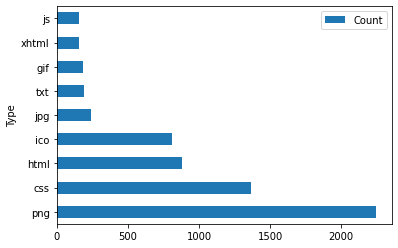

In [ ]:
df = pd.DataFrame(ordered_type_counts, columns=['Type', 'Count'])
df.plot.barh(x = 'Type')

## <b>Zadanie 4</b>
#### Narysować mapę z lokalizacjami klientów

In [ ]:
regex = '([(\d\.)]+)'

ips = lines.map(lambda s: (re.match(regex, s).group(0), 1))
ips = ips.reduceByKey(lambda a, b: a + b).map(lambda s: s[0])

import ipinfo, pprint
access_token = 'db1419af859373'
handler = ipinfo.getHandler(access_token)
details = handler.getBatchDetails(ips.collect()).items()
details

dict_items([('83.149.9.216', {'ip': '83.149.9.216', 'hostname': 'gprs-client-83.149.9.216.misp.ru', 'city': 'Moscow', 'region': 'Moscow', 'country': 'RU', 'loc': '55.7522,37.6156', 'org': 'AS31133 PJSC MegaFon', 'postal': '101000', 'timezone': 'Europe/Moscow', 'country_name': 'Russia', 'latitude': '55.7522', 'longitude': '37.6156'}), ('46.105.14.53', {'ip': '46.105.14.53', 'hostname': '53.ip-46-105-14.eu', 'city': 'Annweiler am Trifels', 'region': 'Rheinland-Pfalz', 'country': 'DE', 'loc': '49.2061,7.9753', 'org': 'AS16276 OVH SAS', 'postal': '76855', 'timezone': 'Europe/Berlin', 'country_name': 'Germany', 'latitude': '49.2061', 'longitude': '7.9753'}), ('123.125.71.35', {'ip': '123.125.71.35', 'hostname': 'baiduspider-123-125-71-35.crawl.baidu.com', 'city': 'Beijing', 'region': 'Beijing', 'country': 'CN', 'loc': '39.9075,116.3972', 'org': 'AS4808 China Unicom Beijing Province Network', 'timezone': 'Asia/Shanghai', 'country_name': 'China', 'latitude': '39.9075', 'longitude': '116.3972'

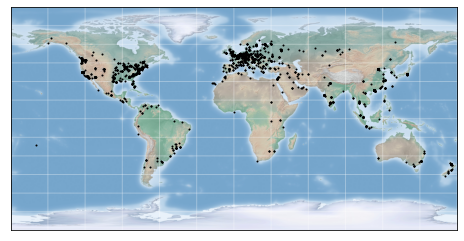

In [ ]:
import matplotlib as mlt
from mpl_toolkits.basemap import Basemap
import numpy as np

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')


fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None )
draw_map(m)

for detail in details:
  loc = detail[1]['loc']
  location = loc.split(',')
  x, y = float(location[1]), float(location[0])
  plt.plot(x, y, 'ok', markersize=1)




## <b>Zadanie 5</b>
#### Oszacować jaki procent ruchu generują boty

In [ ]:
regex = '\" \".*(bot|crawler|spider|Bot|Crawler|Spider).*\"'

is_bot = lines.map(lambda s: (re.search(regex, s) is not None, 1)).reduceByKey(lambda a, b: a + b).collect()

sum = 0
for b in is_bot:
  if b[0]:
    bots_number = b[1]
  sum += b[1]

print((bots_number / sum) * 100, '%')

12.9 %
